# Hierarchical Clustering
## Weather Station Clustering

Hierarchical clustering (**HCA**) is clustering analysis which seeks to build a hierarchy of clusters.

There are 2 general strategies for this:
1. *Agglomerative* (bottom up): Each datapoint begins in its own cluster, and these clusters merge with other clusters as one moves up the hierarchy.
2. *Divisive* (top down): Every datapoint begin in 1 cluster, and splits are performed recursively as one moves down the hierarchy.

*Updated version of 'Weather Station Clustering' by Saeed Aghabozorgi & Polong Lin*

<u>**Table of Contents**</u>
 - <a href="#D">Data</a>
 - <a href="#DC">Data Cleaning</a>
 - <a href="#DV">Data Visualization</a>
 - <a href="#E">Partial Dataset Example</a>
 - <a href="#DP">Data Preprocessing</a>
 - <a href="#C">Clustering</a>
 - <a href="#RV">Cluster Visualization</a>

#### Downloading necessary libraries

In [14]:
#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install scipy

#### Importing necessary libraries

In [37]:
import csv
import random
import numpy as np
import pandas as pd

# Plotting
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from scipy import zeros as sci_zeros
from scipy.spatial.distance import euclidean

%matplotlib inline

## <a name="D">Data</a>
We will be using data from Environment Canada about weather stations for the year of 2014.

### Download data
The data that we will use in this notebook is currently hosted on `box.ibm.com`. We will download this file using the `wget` bash command. The below line will download the file and rename it to `weather-stations20140101-20141231.csv` and place it in the current working directory.

You can manipulate the first argument after `-O` to control where the file is saved. The first argument is the relative path to store the file. Please note the import command in the next step must be changed so the correct file is imported.

In [3]:
!wget -O weather-stations20140101-20141231.csv https://ibm.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Read in data

In [4]:
df = pd.read_csv('eng-climate-summaries-All-2_2015.csv')
df.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


### Data Structure
Here is the structure of the data imported: 

- Stn_Name:::: Station Name
- Lat :::: Latitude (North + , degrees)
- Long :::: Longitude (West - , degrees)
- Prov :::: Province
- Tm :::: Mean Temperature (Â°C)
- DwTm :::: Days without Valid Mean Temperature
- D :::: Mean Temperature difference from Normal (1981-2010) (Â°C)
- Tx :::: Highest Monthly Maximum Temperature (Â°C)
- DwTx :::: Days without Valid Maximum Temperature
- Tn :::: Lowest Monthly Minimum Temperature (Â°C)
- DwTn :::: Days without Valid Minimum Temperature
- S :::: Snowfall (cm)
- DwS :::: Days without Valid Snowfall
- S%N :::: Percent of Normal (1981-2010) Snowfall
- P :::: Total Precipitation (mm)
- DwP :::: Days without Valid Precipitation
- P%N :::: Percent of Normal (1981-2010) Precipitation
- S_G :::: Snow on the ground at the end of the month (cm)
- Pd :::: Number of days with Precipitation 1.0 mm or more
- BS :::: Bright Sunshine (hours)
- DwBS :::: Days without Valid Bright Sunshine
- BS% :::: Percent of Normal (1981-2010) Bright Sunshine
- HDD :::: Degree Days below 18 Â°C
- CDD :::: Degree Days above 18 Â°C
- Stn_No :::: Climate station identifier (first 3 digits indicate drainage basin, last 4 characters are for sorting alphabetically).
- NA :::: Not Available

## <a name="DC">Data Cleaning</a>
We will only be doing light cleaning of this dataset. 

### Info
Let's get some information regarding the nulls in the dataset:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 25 columns):
Stn_Name    1341 non-null object
Lat         1341 non-null float64
Long        1341 non-null float64
Prov        1341 non-null object
Tm          1256 non-null float64
DwTm        1256 non-null float64
D           357 non-null float64
Tx          1260 non-null float64
DwTx        1260 non-null float64
Tn          1260 non-null float64
DwTn        1260 non-null float64
S           586 non-null float64
DwS         586 non-null float64
S%N         198 non-null float64
P           1227 non-null float64
DwP         1227 non-null float64
P%N         209 non-null float64
S_G         798 non-null float64
Pd          1227 non-null float64
BS          0 non-null float64
DwBS        0 non-null float64
BS%         0 non-null float64
HDD         1256 non-null float64
CDD         1256 non-null float64
Stn_No      1341 non-null object
dtypes: float64(22), object(3)
memory usage: 262.0+ KB


### Drop some null rows/columns
We will drop the rows that are null in the `Tm`,`Tn`,`Tx`,`xm`, and `ym` columns, we will also drop the columns `BS`,`DwBS`, and `BS%` because they have no values.

In [6]:
# Drop Tm','Tn','Tx','xm','ym' null rows
df = df[np.isfinite(df['Tm'])]
df = df[np.isfinite(df['Tn'])]
df = df[np.isfinite(df['Tx'])]
# df = df[np.isfinite(df['xm'])]
# df = df[np.isfinite(df['ym'])]

# Drop BS,DwBS, and BS% columns
df.drop(['BS','DwBS','BS%'],axis=1,inplace=True)
df.info()

df.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 1340
Data columns (total 22 columns):
Stn_Name    1255 non-null object
Lat         1255 non-null float64
Long        1255 non-null float64
Prov        1255 non-null object
Tm          1255 non-null float64
DwTm        1255 non-null float64
D           357 non-null float64
Tx          1255 non-null float64
DwTx        1255 non-null float64
Tn          1255 non-null float64
DwTn        1255 non-null float64
S           511 non-null float64
DwS         511 non-null float64
S%N         182 non-null float64
P           1143 non-null float64
DwP         1143 non-null float64
P%N         193 non-null float64
S_G         733 non-null float64
Pd          1143 non-null float64
HDD         1255 non-null float64
CDD         1255 non-null float64
Stn_No      1255 non-null object
dtypes: float64(19), object(3)
memory usage: 225.5+ KB


## <a name="DV">Data Visualization</a>

In [7]:
plt.figure(figsize=(14,10))

Long = [-140,-50] # Longitude Range
Lat = [40,65] # Latitude Range

# Query dataframe for long/lat in the above range
df = df[
    (df['Long'] > Long[0])
    & (df['Long'] < Long[1])
    & (df['Lat'] > Lat[0])
    & (df['Lat'] < Lat[1])
]

# Create basemap map
#my_map = Basemap(
#    projection='merc',
#    resolution='l',
#    area_thresh = 1000.0,
#    llcrnrlon = Long[0],     # Lower latitude
#    urcrnrlon = Long[1],     # Upper longitude
#    llcrnrlat = Lat[0],      # Lower latitude
#    urcrnrlat = Lat[1]       # Upper latitude
#)

# Basemap map drawing parameters
my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color='green',alpha=0.3)
my_map.shadedrelief()

# Get x,y position of points on map using my_map
my_longs = df.Long.values
my_lats = df.Lat.values

X,Y = my_map(my_longs, my_lats)

# Add x,y to dataframe
df['xm'] = X
df['ym'] = Y

# Draw weather stations on map:
for (x,y) in zip(X,Y):
    my_map.plot(x,y,
                markerfacecolor=([1,0,0]),
                marker = 'o',
                markersize = 5,
                alpha = 0.75)

NameError: name 'my_map' is not defined

<Figure size 1008x720 with 0 Axes>

## <a name="E">Partial Dataset Example</a>
Let's try heirarchical clustering an random sample of 30 points from the dataset and plot the results.

In [11]:
df.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwS,S%N,P,DwP,P%N,S_G,Pd,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,178.8,0.0,NaN,0.0,12.0,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,0.0,258.6,0.0,104.0,0.0,12.0,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,264.6,9.0,NaN,NaN,11.0,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,168.4,2.0,NaN,NaN,11.0,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,NaN,NaN,81.0,8.0,NaN,NaN,12.0,258.6,0.0,1012710


In [13]:
len(df)

1188

In [12]:
sDF.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwS,S%N,P,DwP,P%N,S_G,Pd,HDD,CDD,Stn_No
0,SABLE ISLAND,43.932,-60.009,NS,-1.2,1.0,NaN,10.9,1.0,-12.7,...,NaN,NaN,159.5,2.0,NaN,NaN,19.0,518.8,0.0,8204700
1,BELLEVILLE,44.151,-77.395,ON,-14.3,0.0,-9.2,-2.0,0.0,-33.0,...,0.0,178.0,51.1,0.0,88.0,40.0,15.0,904.6,0.0,6150689
2,CORONACH,49.117,-105.517,SK,-12.3,0.0,-3.4,8.5,0.0,-34.0,...,0.0,180.0,25.7,0.0,182.0,21.0,11.0,847.9,0.0,4031844
3,CALLAGHAN VALLEY,50.144,-123.111,BC,3.3,0.0,NaN,12.4,0.0,-4.7,...,NaN,NaN,246.3,0.0,NaN,0.0,12.0,411.0,0.0,1101300
4,STE MARTINE,45.217,-73.850,QC,-15.4,10.0,-7.5,-3.5,10.0,-26.5,...,5.0,NaN,43.5,5.0,NaN,30.0,10.0,600.4,0.0,7027540


In [14]:
len(sDF)

30

In [8]:
n_samples = 30 # samples to grab

sDF = df.sample(n=n_samples)

In [15]:
sDF = sDF.reset_index(drop=True)

### Preprocessing

In [29]:
sDF['Tm']

0     -1.2
1    -14.3
2    -12.3
3      3.3
4    -15.4
5     -7.4
6      0.3
7    -17.9
8    -17.4
9     -7.0
10    -7.2
11   -12.4
12   -17.4
13     3.4
14   -17.4
15   -15.2
16   -14.2
17   -19.6
18    -2.5
19   -17.9
20    -1.4
21   -19.2
22    -4.3
23   -11.1
24     6.0
25    -8.0
26   -24.9
27   -17.1
28   -23.3
29     1.7
Name: Tm, dtype: float64

In [28]:
sDF

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwS,S%N,P,DwP,P%N,S_G,Pd,HDD,CDD,Stn_No
0,SABLE ISLAND,43.932,-60.009,NS,-1.2,1.0,NaN,10.9,1.0,-12.7,...,NaN,NaN,159.5,2.0,NaN,NaN,19.0,518.8,0.0,8204700
1,BELLEVILLE,44.151,-77.395,ON,-14.3,0.0,-9.2,-2.0,0.0,-33.0,...,0.0,178.0,51.1,0.0,88.0,40.0,15.0,904.6,0.0,6150689
2,CORONACH,49.117,-105.517,SK,-12.3,0.0,-3.4,8.5,0.0,-34.0,...,0.0,180.0,25.7,0.0,182.0,21.0,11.0,847.9,0.0,4031844
3,CALLAGHAN VALLEY,50.144,-123.111,BC,3.3,0.0,NaN,12.4,0.0,-4.7,...,NaN,NaN,246.3,0.0,NaN,0.0,12.0,411.0,0.0,1101300
4,STE MARTINE,45.217,-73.850,QC,-15.4,10.0,-7.5,-3.5,10.0,-26.5,...,5.0,NaN,43.5,5.0,NaN,30.0,10.0,600.4,0.0,7027540
5,YARMOUTH A,43.827,-66.088,NS,-7.4,0.0,NaN,4.8,0.0,-17.0,...,0.0,NaN,149.9,1.0,NaN,28.0,18.0,712.2,0.0,8206495
6,TERRACE A,54.469,-128.578,BC,0.3,0.0,NaN,8.3,0.0,-8.0,...,0.0,NaN,191.5,1.0,NaN,NaN,11.0,495.3,0.0,1068134
7,AROOSTOOK,46.712,-67.716,NB,-17.9,0.0,-7.4,-1.0,0.0,-34.0,...,0.0,133.0,67.0,0.0,105.0,66.0,9.0,1005.8,0.0,8100300
8,VIRDEN WATER,49.842,-100.934,MB,-17.4,0.0,NaN,0.0,0.0,-34.0,...,0.0,NaN,27.0,0.0,NaN,43.0,4.0,990.9,0.0,5012961
9,PEORIA AGDM,55.621,-118.293,AB,-7.0,7.0,NaN,10.5,7.0,-31.2,...,NaN,NaN,11.8,12.0,NaN,NaN,3.0,525.9,0.0,3075160


In [35]:
normalize(np.matrix(sDF['Tm']))

0.08188526554703593

In [16]:
nTemp = normalize(np.matrix(sDF.Tm.values), axis=1)
nTemp = nTemp[0] # convert to 1D array
nTemp

array([-0.01637705, -0.19515988, -0.16786479,  0.0450369 , -0.21017218,
       -0.10099183,  0.00409426, -0.24429104, -0.23746727, -0.09553281,
       -0.09826232, -0.16922955, -0.23746727,  0.04640165, -0.23746727,
       -0.20744267, -0.19379513, -0.26749187, -0.03411886, -0.24429104,
       -0.01910656, -0.26203285, -0.05868444, -0.15148774,  0.08188527,
       -0.10918035, -0.33982385, -0.23337301, -0.31798778,  0.02320083])

### Calculate element-wise temperature differences

In [36]:
sci_zeros([nTemp.size,nTemp.size])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [26]:
# empty matrix is fill
D = sci_zeros([nTemp.size,nTemp.size])

# Find all element wise temp differences
for i in range(nTemp.size):
    for j in range(nTemp.size):
        D[i,j] = abs(nTemp[i]-nTemp[j])

In [27]:
D

array([[0.        , 0.17878283, 0.15148774, 0.06141395, 0.19379513,
        0.08461477, 0.02047132, 0.22791399, 0.22109022, 0.07915576,
        0.08188527, 0.1528525 , 0.22109022, 0.0627787 , 0.22109022,
        0.19106562, 0.17741808, 0.25111481, 0.01774181, 0.22791399,
        0.00272951, 0.2456558 , 0.04230739, 0.13511069, 0.09826232,
        0.0928033 , 0.3234468 , 0.21699595, 0.30161073, 0.03957788],
       [0.17878283, 0.        , 0.02729509, 0.24019678, 0.0150123 ,
        0.09416806, 0.19925415, 0.04913116, 0.04230739, 0.09962707,
        0.09689756, 0.02593033, 0.04230739, 0.24156153, 0.04230739,
        0.01228279, 0.00136475, 0.07233198, 0.16104102, 0.04913116,
        0.17605332, 0.06687297, 0.13647544, 0.04367214, 0.27704515,
        0.08597953, 0.14466397, 0.03821312, 0.1228279 , 0.21836071],
       [0.15148774, 0.02729509, 0.        , 0.21290169, 0.04230739,
        0.06687297, 0.17195906, 0.07642625, 0.06960248, 0.07233198,
        0.06960248, 0.00136475, 0.06960248, 0.

### Hierarchical Clustering

In [41]:
Y = sch.linkage(D, method='centroid')

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


### Plot 1st Dendrogram

In [48]:
sDF['Tm'][Z1['leaves']]

24     6.0
3      3.3
13     3.4
6      0.3
29     1.7
25    -8.0
5     -7.4
9     -7.0
10    -7.2
22    -4.3
18    -2.5
0     -1.2
20    -1.4
26   -24.9
28   -23.3
17   -19.6
21   -19.2
7    -17.9
19   -17.9
27   -17.1
14   -17.4
8    -17.4
12   -17.4
1    -14.3
16   -14.2
4    -15.4
15   -15.2
23   -11.1
2    -12.3
11   -12.4
Name: Tm, dtype: float64

[]

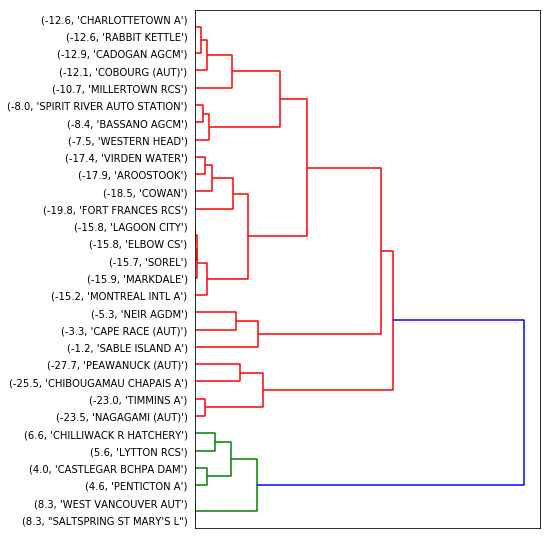

In [42]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])


Z1 = sch.dendrogram(Y, orientation='right')
labels = zip(map(lambda x: round(x,2),
                     sDF['Tm'][Z1['leaves']]),
                     sDF['Stn_Name'][Z1['leaves']])
ax1.set_xticks([])
ax1.set_yticklabels(labels)

plt.plot() # supress prints

## <a name="DP">Data Preprocessing</a>
Now, we will continue w/ heirarchical clustering with the entire dataset. First, we will normalize the data:

In [43]:
X = normalize(np.matrix(df.xm.values), axis=1)[0]
Y = normalize(np.matrix(df.ym.values), axis=1)[0]
Tm = normalize(np.matrix(df.Tm.values), axis=1)[0]
Tn = normalize(np.matrix(df.Tn.values), axis=1)[0]
Tx = normalize(np.matrix(df.Tx.values), axis=1)[0]

data=zip(Tm,Tn,Tx,X,Y)

In [44]:
# Grab values from DF
data = normalize(np.matrix(df[['Tm','Tn','Tx','xm','ym']].values), axis=1)
print('Shape:',data.shape)
print(data)

Shape: (1188, 5)
[[ 3.58976212e-06  4.37775868e-07  5.90997422e-06  7.91413958e-01
   6.11280580e-01]
 [ 3.12720065e-06 -1.34022885e-06  6.70114424e-06  7.88201573e-01
   6.15417160e-01]
 [ 3.02754010e-06 -1.11306621e-06  7.12362377e-06  7.89536091e-01
   6.13704131e-01]
 ...
 [-2.66011766e-06 -3.52138526e-06 -1.47178641e-06  9.38458983e-01
   3.45390701e-01]
 [-2.42555457e-06 -3.45747910e-06 -6.17027039e-07  9.65771991e-01
   2.59392487e-01]
 [-3.29796352e-06 -5.57201057e-06 -1.61921675e-06  9.68224599e-01
   2.50082240e-01]]


### Calculate tuple-wise distances

In [45]:
D = sci_zeros([data.shape[0],data.shape[0]])

for i in range(data.shape[0]):
    for j in range (data.shape[0]):
        D[i,j] = euclidean(data[i],data[j])

D

array([[0.        , 0.00523743, 0.00306594, ..., 0.30384152, 0.39271612,
        0.40215202],
       [0.00523743, 0.        , 0.0021715 , ..., 0.30901712, 0.39785025,
        0.4072811 ],
       [0.00306594, 0.0021715 , 0.        , ..., 0.30687151, 0.39572191,
        0.40515486],
       ...,
       [0.30384152, 0.30901712, 0.30687151, ..., 0.        , 0.09023133,
        0.09984836],
       [0.39271612, 0.39785025, 0.39572191, ..., 0.09023133, 0.        ,
        0.00962788],
       [0.40215202, 0.4072811 , 0.40515486, ..., 0.09984836, 0.00962788,
        0.        ]])

## <a name="C">Clustering</a>

In [43]:
Y = sch.linkage(D, method='centroid')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


## <a name="RV">Cluster Visualization</a>

### Visualize Dendrograms
We will visualize the dendrograms, like we did before with just the sample database.

In [47]:
sDF[Z1['leaves']]

KeyError: '[24  3 13  6 29 25  5  9 10 22 18  0 20 26 28 17 21  7 19 27 14  8 12  1\n 16  4 15 23  2 11] not in index'

[]

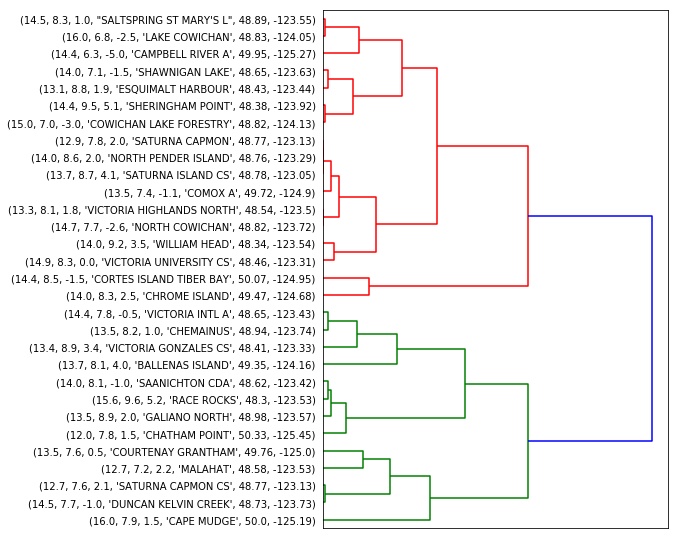

In [45]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get dendrograms
Z1 = sch.dendrogram(Y, orientation='right')

# Get labels
labels = zip(
    map(lambda x: round(x,2), df.Tx[Z1['leaves']]),
    map(lambda x: round(x,2), df.Tm[Z1['leaves']]),
    map(lambda x: round(x,2), df.Tn[Z1['leaves']]),
    df['Stn_Name'][Z1['leaves']],
    map(lambda x: round(x,2), df.Lat[Z1['leaves']]),
    map(lambda x: round(x,2), df.Long[Z1['leaves']])
)

ax1.set_xticks([])
ax1.set_yticklabels(labels)

plt.plot()

### Get labels
Get clustering results and append to dataframe

In [51]:
labels = sch.fcluster(Y, 0.8*D.max(), 'distance')
df["hier_Clusters"]=labels-1
df[["Stn_Name","Tx","Tm","hier_Clusters"]].head()

,Stn_Name,Tx,Tm,hier_Clusters
0,CHEMAINUS,13.5,8.2,22
1,COWICHAN LAKE FORESTRY,15.0,7.0,22
2,LAKE COWICHAN,16.0,6.8,22
3,DUNCAN KELVIN CREEK,14.5,7.7,22
4,ESQUIMALT HARBOUR,13.1,8.8,23


### Visualize on Map
Now we will visualize the results on an actual map

Cluster 0, Avg Temp: -17.86
Cluster 1, Avg Temp: -14.65
Cluster 2, Avg Temp: -13.15
Cluster 3, Avg Temp: -12.866666666666667
Cluster 4, Avg Temp: -13.799999999999999
Cluster 5, Avg Temp: 2.7624999999999993
Cluster 6, Avg Temp: -2.055555555555555
Cluster 7, Avg Temp: -4.45
Cluster 8, Avg Temp: -7.336363636363635
Cluster 9, Avg Temp: -7.825
Cluster 10, Avg Temp: -6.111111111111111
Cluster 11, Avg Temp: -17.680769230769222
Cluster 12, Avg Temp: -10.972222222222223
Cluster 13, Avg Temp: -14.364687499999999
Cluster 14, Avg Temp: -20.552727272727278
Cluster 15, Avg Temp: -22.6125
Cluster 16, Avg Temp: -23.210526315789473
Cluster 17, Avg Temp: -4.43793103448276
Cluster 18, Avg Temp: -8.569230769230769
Cluster 19, Avg Temp: -6.422727272727273
Cluster 20, Avg Temp: -2.252380952380952
Cluster 21, Avg Temp: 1.0960784313725487
Cluster 22, Avg Temp: -4.0606060606060606
Cluster 23, Avg Temp: -4.856701030927836
Cluster 24, Avg Temp: -12.170491803278688
Cluster 25, Avg Temp: -18.693478260869565
Cluste

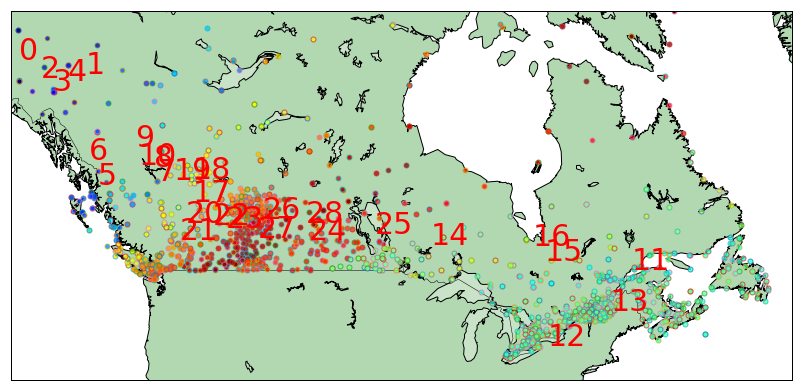

In [52]:
plt.figure(figsize=(14,10))

Long = [-140,-50] # Longitude Range
Lat = [40,65] # Latitude Range

# Query dataframe for long/lat in the above range
df = df[
    (df['Long'] > Long[0])
    & (df['Long'] < Long[1])
    & (df['Lat'] > Lat[0])
    & (df['Lat'] < Lat[1])
]

# Create basemap map
my_map = Basemap(
    projection='merc',
    resolution='l',
    area_thresh = 1000.0,
    llcrnrlon = Long[0],     # Lower latitude
    urcrnrlon = Long[1],     # Upper longitude
    llcrnrlat = Lat[0],      # Lower latitude
    urcrnrlat = Lat[1]       # Upper latitude
)

# Basemap map drawing parameters
my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color='green',alpha=0.3)
my_map.shadedrelief()

# Create color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, len(set(df.hier_Clusters.values))))

# Plot x,y points, and color by cluster
for index,row in df.iterrows():
    my_map.plot(row.xm, row.ym, 
                markerfacecolor=colors[row.hier_Clusters],
                marker = 'o',
                markersize = 5,
                alpha = 0.75
               )
# Label clusters                
for i in range(len(set(labels))):
    cluster = df[df.hier_Clusters == i][["Stn_Name","Tm","xm","ym","hier_Clusters"]]
    
    # Get centroid of cluster
    xc = np.mean(cluster.xm)
    yc = np.mean(cluster.ym)
    
    # Get mean temp of cluster
    Tavg = np.mean(cluster.Tm)
    
    # label cluster on map
    plt.text(xc,yc,str(i),fontsize=30,color='red')
    
    # Print average temperatures
    print ("Cluster "+str(i)+', Avg Temp: '+ str(np.mean(cluster.Tm)))